In [1]:
!pip install keras
!pip install sklearn
!pip install matplotlib
!pip install -U -q PyDrive

In [2]:
from keras import backend as K
K.clear_session()

Using TensorFlow backend.


In [0]:
from keras import backend as K
cfg = K.tf.ConfigProto()
cfg.gpu_options.allow_growth = True
K.set_session(K.tf.Session(config=cfg))

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
file_import = drive.CreateFile({'id':'1p1bsltfTcIrZ_kfE6kwGTPzcdXorHbb2'})
file_import.GetContentFile('colab_setup.py') 
from colab_setup import setup

setup(drive)

In [6]:
!ls

colab_setup.py			 roc_auc_callback.py	X_train.npy
custom_fast_text_embeddings.npy  sample_submission.csv	X_val.npy
datalab				 train_model.py		y_test.npy
fast_text_embeddings.npy	 X_submission.npy	y_train_full.npy
plot_history.py			 X_test.npy		y_train.npy
__pycache__			 X_train_full.npy	y_val.npy


In [0]:
import numpy as np
import os

from plot_history import plot_history
from roc_auc_callback import RocAucCallback
from train_model import train_with_cv, train_with_submitting, evaluate_on_test

from keras.layers import *
from keras.layers.merge import *
from keras.initializers import *
from keras.models import Model

In [0]:
from keras.optimizers import *
from keras.initializers import *
from keras.layers import *
from keras.layers.merge import *
from keras.models import *

residual_convolution_options = dict({
    'dropout_mode': 'spatial',
    'dropout_rate': 0.2,
    'filters': 128,
    'kernel_size': 1,
    'strides': 1,
    'padding': 'same',
    'activation': 'elu',
    'should_preactivate': True
})

def convolution_block(input_layer, options):
    convolution_input = Input(shape=[
        int(input_layer.shape[1]),
        int(input_layer.shape[2])
    ])

    convolution_block = convolution_input

    if(options['should_preactivate']):
        convolution_block = BatchNormalization()(convolution_block)
        convolution_block = Activation(options['activation'])(convolution_block)
        convolution_block = Conv1D(options['filters'], options['kernel_size'], strides=options['strides'],
                                   padding=options['padding'], activation='linear', kernel_initializer='he_normal')(convolution_block)
    else:
        convolution_block = Conv1D(options['filters'], options['kernel_size'], strides=options['strides'],
                                   padding=options['padding'], activation='linear', kernel_initializer='he_normal')(convolution_block)
        convolution_block = BatchNormalization()(convolution_block)
        convolution_block = Activation(options['activation'])(convolution_block)

    convolution_output = convolution_block

    if(options['dropout_mode'] == 'spatial'):
        convolution_output = SpatialDropout1D(options['dropout_rate'])(convolution_output)
    if(options['dropout_mode']== 'vanilla'):
        convolution_output = Dropout(options['dropout_rate'])(convolution_output)

    return Model(inputs=[convolution_input], outputs=[convolution_output])(input_layer)

In [0]:
def residual_add_block(input_layer, should_pool):
    convolution_input = Input(shape=[
        int(input_layer.shape[1]),
        int(input_layer.shape[2])
    ])
    
    residual_block_pool = convolution_input

    if(should_pool):
        residual_block_pool = MaxPooling1D(pool_size=2, strides=2, padding='same')(convolution_input)

    residual_block = add([
        residual_block_pool,
        convolution_block(residual_block_pool, residual_convolution_options)
    ])
    residual_block = add([
        residual_block,
        convolution_block(residual_block, residual_convolution_options)
    ])
    
    convolution_output = add([residual_block, residual_block_pool])

    return Model(inputs=[convolution_input], outputs=[convolution_output])(input_layer)

In [0]:
def yoon_kim_feature_extractor(input_layer, filters):
    extractor_block_input = Input(shape=[
        int(input_layer.shape[1]),
        int(input_layer.shape[2])
    ])

    block_1_conv_1 = Conv1D(filters, 1, activation = 'linear', padding = 'same', kernel_initializer = 'he_normal')(extractor_block_input)
    block_1_batchnorm1 = BatchNormalization()(block_1_conv_1)
    block_1_batchnorm1 = ELU()(block_1_batchnorm1)
    block_1_max_pool1 = GlobalMaxPooling1D()(block_1_batchnorm1)

    block_1_conv_2 = Conv1D(filters, 2, activation = 'linear', padding = 'same', kernel_initializer = 'he_normal')(extractor_block_input)
    block_1_batchnorm2 = BatchNormalization()(block_1_conv_2)
    block_1_batchnorm2 = ELU()(block_1_batchnorm2)
    block_1_max_pool2 = GlobalMaxPooling1D()(block_1_batchnorm2)

    block_1_conv_3 = Conv1D(filters, 3, activation = 'linear', padding = 'same', kernel_initializer = 'he_normal')(extractor_block_input)
    block_1_batchnorm3 = BatchNormalization()(block_1_conv_3)
    block_1_batchnorm3 = ELU()(block_1_batchnorm3)
    block_1_max_pool3 = GlobalMaxPooling1D()(block_1_batchnorm3)

    block_1_conv_4 = Conv1D(filters, 5, activation = 'linear', padding = 'same', kernel_initializer = 'he_normal')(extractor_block_input)
    block_1_batchnorm4 = BatchNormalization()(block_1_conv_4)
    block_1_batchnorm4 = ELU()(block_1_batchnorm4)
    block_1_max_pool4 = GlobalMaxPooling1D()(block_1_batchnorm4)

    features = concatenate([
        block_1_max_pool1, 
        block_1_max_pool2, 
        block_1_max_pool3, 
        block_1_max_pool4
    ])
    
    extractor_block_output = Dropout(0.2)(features)
    
    return Model(
        inputs=[extractor_block_input], 
        outputs=[extractor_block_output]
    )(input_layer)

In [0]:
def classification_block(input_layer, dropout_rate = 0.2):
      
    model = Dense(256, activation = 'linear', kernel_initializer = 'he_normal')(input_layer)
    model = BatchNormalization()(model)
    model = ELU()(model)
    model = Dropout(dropout_rate)(model)
    
    model = Dense(256, activation = 'linear', kernel_initializer = 'he_normal')(model)
    model = BatchNormalization()(model)
    model = ELU()(model)
    model = Dropout(dropout_rate)(model)

    classification_block_output = Dense(6, activation='sigmoid', kernel_initializer = 'glorot_normal')(model)
    
    return classification_block_output

In [12]:
max_words= 30000
max_words_length = 400
embedding_dimension = 300

input_layer = Input(shape=(max_words_length,))

pretrained_embedding_layer = Embedding(
    max_words, 
    output_dim=embedding_dimension, 
    input_length=max_words_length,
    weights = [np.load('fast_text_embeddings.npy')],
    trainable = False
)(input_layer)
pretrained_embedding_layer = SpatialDropout1D(0.2)(pretrained_embedding_layer)

custom_embedding_layer = Embedding(
    max_words, 
    output_dim=embedding_dimension, 
    input_length=max_words_length,
    weights = [np.load('custom_fast_text_embeddings.npy')],
    trainable = False
)(input_layer)
custom_embedding_layer = SpatialDropout1D(0.2)(custom_embedding_layer)

averaged_embedding_layer = Average()([pretrained_embedding_layer, custom_embedding_layer])
averaged_embedding_layer = SpatialDropout1D(0.2)(averaged_embedding_layer)
averaged_embedding_layer_scaled = convolution_block(averaged_embedding_layer, residual_convolution_options)

model = residual_add_block(averaged_embedding_layer_scaled, should_pool = False)
model = residual_add_block(model, should_pool = True)
model = residual_add_block(model, should_pool = True)
model = residual_add_block(model, should_pool = True)

output_layer = yoon_kim_feature_extractor(model, residual_convolution_options['filters'])
output_layer = classification_block(output_layer)

model = Model(input_layer, output_layer)

model.compile(loss='binary_crossentropy', 
            optimizer='Adam',
            metrics=['accuracy'])          

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 400)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 400, 300)     9000000     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 400, 300)     9000000     input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 400, 300)     0           embedding_1[0][0]                
__________________________________________________________________________________________________
spatial_dr

In [13]:
history = train_with_cv(model, epochs=64, batchSize=32, rocEvery = 2)

Train on 102124 samples, validate on 25532 samples
Epoch 1/64
 21376/102124 [=====>........................] - ETA: 3:25 - loss: 0.1217 - acc: 0.9595

 62208/102124 [=================>............] - ETA: 1:32 - loss: 0.0855 - acc: 0.9709

102112/102124 [============================>.] - ETA: 0s - loss: 0.0754 - acc: 0.9739

102124/102124 [==============================] - 246s 2ms/step - loss: 0.0754 - acc: 0.9739 - val_loss: 0.0492 - val_acc: 0.9813
Epoch 2/64
 13952/102124 [===>..........................] - ETA: 3:14 - loss: 0.0591 - acc: 0.9783

102112/102124 [============================>.] - ETA: 0s - loss: 0.0546 - acc: 0.9802

102124/102124 [==============================] - 238s 2ms/step - loss: 0.0546 - acc: 0.9802 - val_loss: 0.0444 - val_acc: 0.9830
roc-auc: 0.9834 - roc-auc_val: 0.98                                                                                                    
Epoch 3/64
  8736/102124 [=>............................] - ETA: 3:24 - loss: 0.0521 - acc: 0.9806

 77824/102124 [=====================>........] - ETA: 53s - loss: 0.0512 - acc: 0.9810

102124/102124 [==============================] - 237s 2ms/step - loss: 0.0512 - acc: 0.9810 - val_loss: 0.0478 - val_acc: 0.9816
Epoch 4/64
  4832/102124 [>.............................] - ETA: 3:35 - loss: 0.0452 - acc: 0.9822

 61696/102124 [=================>............] - ETA: 1:28 - loss: 0.0485 - acc: 0.9817

100960/102124 [============================>.] - ETA: 2s - loss: 0.0488 - acc: 0.9816

102124/102124 [==============================] - 237s 2ms/step - loss: 0.0488 - acc: 0.9816 - val_loss: 0.0426 - val_acc: 0.9835
roc-auc: 0.9879 - roc-auc_val: 0.9845                                                                                                    
Epoch 5/64
  8416/102124 [=>............................] - ETA: 3:25 - loss: 0.0499 - acc: 0.9809

 54048/102124 [==============>...............] - ETA: 1:45 - loss: 0.0475 - acc: 0.9821

 91840/102124 [=========================>....] - ETA: 22s - loss: 0.0470 - acc: 0.9822

102124/102124 [==============================] - 236s 2ms/step - loss: 0.0469 - acc: 0.9822 - val_loss: 0.0443 - val_acc: 0.9824
Epoch 6/64
 10080/102124 [=>............................] - ETA: 3:22 - loss: 0.0429 - acc: 0.9837

 48256/102124 [=============>................] - ETA: 1:58 - loss: 0.0452 - acc: 0.9828

 89856/102124 [=========================>....] - ETA: 26s - loss: 0.0456 - acc: 0.9827

102124/102124 [==============================] - 236s 2ms/step - loss: 0.0456 - acc: 0.9827 - val_loss: 0.0421 - val_acc: 0.9837
roc-auc: 0.9902 - roc-auc_val: 0.9866                                                                                                    
Epoch 7/64
  5728/102124 [>.............................] - ETA: 3:29 - loss: 0.0441 - acc: 0.9830

 50464/102124 [=============>................] - ETA: 1:52 - loss: 0.0450 - acc: 0.9826

 98944/102124 [============================>.] - ETA: 6s - loss: 0.0445 - acc: 0.9829

102124/102124 [==============================] - 236s 2ms/step - loss: 0.0445 - acc: 0.9829 - val_loss: 0.0417 - val_acc: 0.9836
Epoch 8/64
 12736/102124 [==>...........................] - ETA: 3:15 - loss: 0.0423 - acc: 0.9842

 56416/102124 [===============>..............] - ETA: 1:40 - loss: 0.0434 - acc: 0.9835

 97344/102124 [===========================>..] - ETA: 10s - loss: 0.0436 - acc: 0.9834

102124/102124 [==============================] - 237s 2ms/step - loss: 0.0437 - acc: 0.9833 - val_loss: 0.0407 - val_acc: 0.9841
roc-auc: 0.9916 - roc-auc_val: 0.9883                                                                                                    
Epoch 9/64
  7552/102124 [=>............................] - ETA: 3:27 - loss: 0.0423 - acc: 0.9832

 80672/102124 [======================>.......] - ETA: 46s - loss: 0.0430 - acc: 0.9835

102124/102124 [==============================] - 236s 2ms/step - loss: 0.0427 - acc: 0.9836 - val_loss: 0.0412 - val_acc: 0.9834
Epoch 10/64
  5856/102124 [>.............................] - ETA: 3:31 - loss: 0.0452 - acc: 0.9826

 92992/102124 [==========================>...] - ETA: 20s - loss: 0.0423 - acc: 0.9836

102124/102124 [==============================] - 236s 2ms/step - loss: 0.0422 - acc: 0.9837 - val_loss: 0.0413 - val_acc: 0.9836

Epoch 00010: ReduceLROnPlateau reducing learning rate to 0.00019614602206274867.
roc-auc: 0.9924 - roc-auc_val: 0.9881                                                                                                    
Epoch 11/64
  5344/102124 [>.............................] - ETA: 3:33 - loss: 0.0465 - acc: 0.9814

 43584/102124 [===========>..................] - ETA: 2:08 - loss: 0.0414 - acc: 0.9840

 94368/102124 [==========================>...] - ETA: 17s - loss: 0.0419 - acc: 0.9838

102124/102124 [==============================] - 236s 2ms/step - loss: 0.0418 - acc: 0.9838 - val_loss: 0.0410 - val_acc: 0.9837
Epoch 12/64
 11008/102124 [==>...........................] - ETA: 3:19 - loss: 0.0407 - acc: 0.9843

 59904/102124 [================>.............] - ETA: 1:32 - loss: 0.0403 - acc: 0.9844

102112/102124 [============================>.] - ETA: 0s - loss: 0.0409 - acc: 0.9841

102124/102124 [==============================] - 236s 2ms/step - loss: 0.0409 - acc: 0.9841 - val_loss: 0.0424 - val_acc: 0.9830
roc-auc: 0.9929 - roc-auc_val: 0.9887                                                                                                    
Epoch 13/64
  8672/102124 [=>............................] - ETA: 3:25 - loss: 0.0405 - acc: 0.9844

 51200/102124 [==============>...............] - ETA: 1:51 - loss: 0.0413 - acc: 0.9838

 89248/102124 [=========================>....] - ETA: 28s - loss: 0.0405 - acc: 0.9841

102124/102124 [==============================] - 237s 2ms/step - loss: 0.0405 - acc: 0.9842 - val_loss: 0.0411 - val_acc: 0.9834
Epoch 14/64
  9088/102124 [=>............................] - ETA: 3:23 - loss: 0.0396 - acc: 0.9842

 46912/102124 [============>.................] - ETA: 2:00 - loss: 0.0402 - acc: 0.9841

 88896/102124 [=========================>....] - ETA: 28s - loss: 0.0400 - acc: 0.9842

102124/102124 [==============================] - 236s 2ms/step - loss: 0.0400 - acc: 0.9842 - val_loss: 0.0419 - val_acc: 0.9831
roc-auc: 0.9934 - roc-auc_val: 0.9888                                                                                                    
Epoch 15/64
  5568/102124 [>.............................] - ETA: 3:31 - loss: 0.0421 - acc: 0.9829

 50656/102124 [=============>................] - ETA: 1:52 - loss: 0.0394 - acc: 0.9845

102112/102124 [============================>.] - ETA: 0s - loss: 0.0393 - acc: 0.9845

102124/102124 [==============================] - 236s 2ms/step - loss: 0.0393 - acc: 0.9845 - val_loss: 0.0417 - val_acc: 0.9832
Epoch 16/64
 13984/102124 [===>..........................] - ETA: 3:16 - loss: 0.0399 - acc: 0.9844

 64576/102124 [=================>............] - ETA: 1:22 - loss: 0.0398 - acc: 0.9843

102112/102124 [============================>.] - ETA: 0s - loss: 0.0392 - acc: 0.9845

102124/102124 [==============================] - 237s 2ms/step - loss: 0.0392 - acc: 0.9845 - val_loss: 0.0416 - val_acc: 0.9834
roc-auc: 0.9938 - roc-auc_val: 0.9888                                                                                                    
Epoch 17/64
  8640/102124 [=>............................] - ETA: 3:23 - loss: 0.0371 - acc: 0.9854

 53696/102124 [==============>...............] - ETA: 1:46 - loss: 0.0382 - acc: 0.9850

100320/102124 [============================>.] - ETA: 3s - loss: 0.0388 - acc: 0.9847

102124/102124 [==============================] - 237s 2ms/step - loss: 0.0389 - acc: 0.9846 - val_loss: 0.0409 - val_acc: 0.9836
Epoch 18/64
 13152/102124 [==>...........................] - ETA: 3:14 - loss: 0.0381 - acc: 0.9847

 61760/102124 [=================>............] - ETA: 1:28 - loss: 0.0388 - acc: 0.9847

 99936/102124 [============================>.] - ETA: 4s - loss: 0.0387 - acc: 0.9847

102124/102124 [==============================] - 236s 2ms/step - loss: 0.0387 - acc: 0.9847 - val_loss: 0.0406 - val_acc: 0.9838
roc-auc: 0.9942 - roc-auc_val: 0.9887                                                                                                    
Epoch 19/64
  8096/102124 [=>............................] - ETA: 3:25 - loss: 0.0361 - acc: 0.9855

 59968/102124 [================>.............] - ETA: 1:32 - loss: 0.0382 - acc: 0.9849

102112/102124 [============================>.] - ETA: 0s - loss: 0.0382 - acc: 0.9849

102124/102124 [==============================] - 237s 2ms/step - loss: 0.0382 - acc: 0.9849 - val_loss: 0.0419 - val_acc: 0.9830
Epoch 20/64
 13984/102124 [===>..........................] - ETA: 3:13 - loss: 0.0365 - acc: 0.9859

 56640/102124 [===============>..............] - ETA: 1:39 - loss: 0.0377 - acc: 0.9851

102112/102124 [============================>.] - ETA: 0s - loss: 0.0381 - acc: 0.9849

102124/102124 [==============================] - 237s 2ms/step - loss: 0.0381 - acc: 0.9849 - val_loss: 0.0407 - val_acc: 0.9838
roc-auc: 0.9944 - roc-auc_val: 0.9888                                                                                                    
Epoch 21/64
  8640/102124 [=>............................] - ETA: 3:23 - loss: 0.0370 - acc: 0.9856

 55936/102124 [===============>..............] - ETA: 1:41 - loss: 0.0381 - acc: 0.9850

 99040/102124 [============================>.] - ETA: 6s - loss: 0.0377 - acc: 0.9850

102124/102124 [==============================] - 236s 2ms/step - loss: 0.0377 - acc: 0.9850 - val_loss: 0.0407 - val_acc: 0.9837

Epoch 00021: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Epoch 22/64
  9408/102124 [=>............................] - ETA: 3:23 - loss: 0.0379 - acc: 0.9851

 46592/102124 [============>.................] - ETA: 2:01 - loss: 0.0368 - acc: 0.9855

102112/102124 [============================>.] - ETA: 0s - loss: 0.0372 - acc: 0.9852

102124/102124 [==============================] - 236s 2ms/step - loss: 0.0372 - acc: 0.9852 - val_loss: 0.0406 - val_acc: 0.9838
roc-auc: 0.9947 - roc-auc_val: 0.9886                                                                                                    
Epoch 23/64
  8704/102124 [=>............................] - ETA: 3:24 - loss: 0.0373 - acc: 0.9850

 50912/102124 [=============>................] - ETA: 1:52 - loss: 0.0377 - acc: 0.9850

 89248/102124 [=========================>....] - ETA: 28s - loss: 0.0373 - acc: 0.9852

102124/102124 [==============================] - 236s 2ms/step - loss: 0.0373 - acc: 0.9853 - val_loss: 0.0414 - val_acc: 0.9834
Epoch 24/64
  8960/102124 [=>............................] - ETA: 3:24 - loss: 0.0379 - acc: 0.9848

 46272/102124 [============>.................] - ETA: 2:02 - loss: 0.0374 - acc: 0.9853

102112/102124 [============================>.] - ETA: 0s - loss: 0.0372 - acc: 0.9854

102124/102124 [==============================] - 237s 2ms/step - loss: 0.0372 - acc: 0.9854 - val_loss: 0.0417 - val_acc: 0.9831
roc-auc: 0.9948 - roc-auc_val: 0.9888                                                                                                    
Epoch 25/64
  8672/102124 [=>............................] - ETA: 3:25 - loss: 0.0356 - acc: 0.9854

 50720/102124 [=============>................] - ETA: 1:53 - loss: 0.0361 - acc: 0.9855

 97248/102124 [===========================>..] - ETA: 10s - loss: 0.0365 - acc: 0.9854

102124/102124 [==============================] - 237s 2ms/step - loss: 0.0366 - acc: 0.9853 - val_loss: 0.0412 - val_acc: 0.9835
Epoch 26/64
 12064/102124 [==>...........................] - ETA: 3:17 - loss: 0.0353 - acc: 0.9857

 69280/102124 [===================>..........] - ETA: 1:12 - loss: 0.0371 - acc: 0.9850

102124/102124 [==============================] - 236s 2ms/step - loss: 0.0368 - acc: 0.9852 - val_loss: 0.0407 - val_acc: 0.9838
roc-auc: 0.995 - roc-auc_val: 0.9888                                                                                                    
Epoch 27/64
   896/102124 [..............................] - ETA: 3:38 - loss: 0.0303 - acc: 0.9890

 40512/102124 [==========>...................] - ETA: 2:14 - loss: 0.0373 - acc: 0.9851

 78720/102124 [======================>.......] - ETA: 51s - loss: 0.0368 - acc: 0.9854

102124/102124 [==============================] - 236s 2ms/step - loss: 0.0365 - acc: 0.9855 - val_loss: 0.0414 - val_acc: 0.9833
Epoch 28/64
  5184/102124 [>.............................] - ETA: 3:33 - loss: 0.0393 - acc: 0.9841

 48032/102124 [=============>................] - ETA: 1:58 - loss: 0.0364 - acc: 0.9852

 94944/102124 [==========================>...] - ETA: 15s - loss: 0.0362 - acc: 0.9856

102124/102124 [==============================] - 236s 2ms/step - loss: 0.0364 - acc: 0.9855 - val_loss: 0.0425 - val_acc: 0.9829
roc-auc: 0.9951 - roc-auc_val: 0.9888                                                                                                    


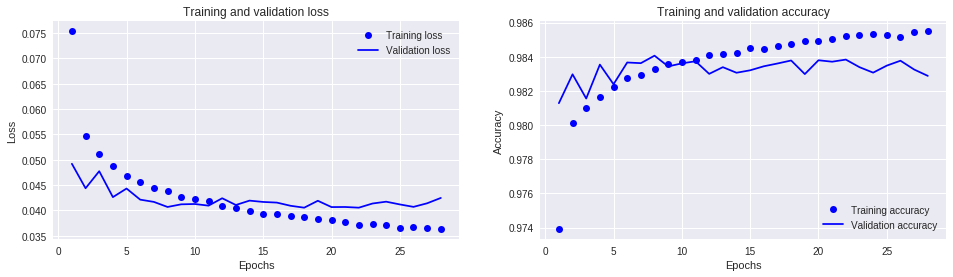

In [14]:
plot_history(history)

In [15]:
print(evaluate_on_test(model))

31915/31915 [==============================] - 17s 544us/step
([0.04129927091460401, 0.9831009317169028], 0.9900892977440101)
